Best configuration: {'num_tables': 20, 'num_waiters': 2, 'num_chefs': 2, 'num_cashiers': 2, 'satisfied_customers': 44, 'impatient_customers': 6, 'avg_order_wait_time': 5.28295689843921, 'avg_cook_time': 13.777129510429619, 'avg_eating_time': 41.38800854956589, 'avg_payment_time': 3.6489602791568028}
Total customers: 50
Satisfied customers: 44
Impatient customers: 6
Average order wait time: 5.28 minutes
Average cook time: 13.78 minutes
Average eating time: 41.39 minutes
Average payment time: 3.65 minutes


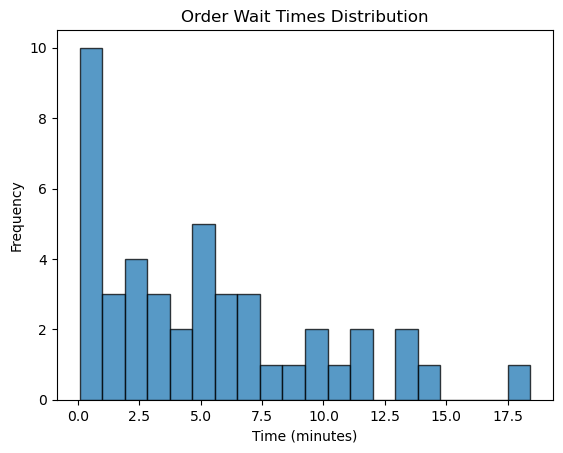

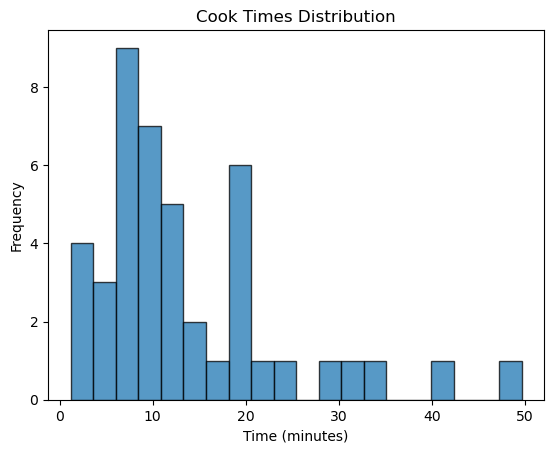

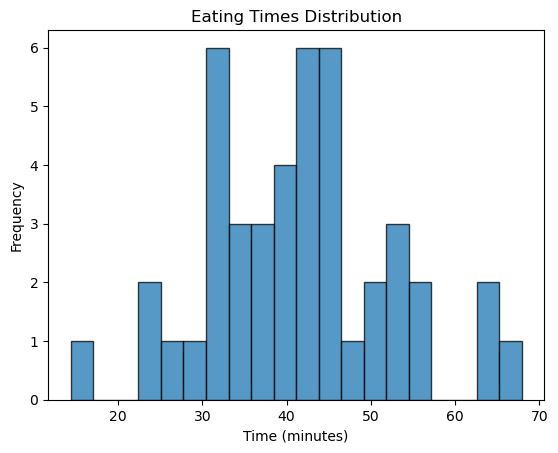

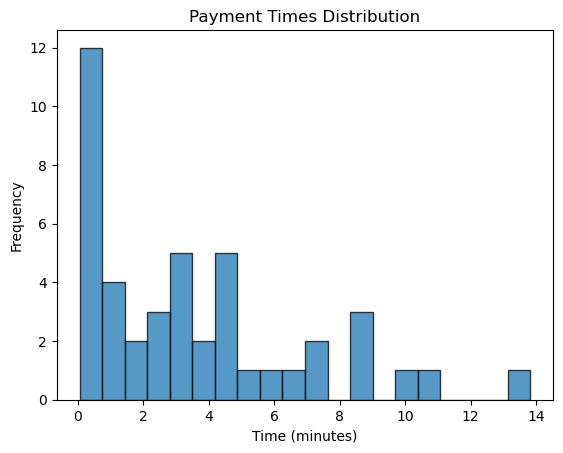

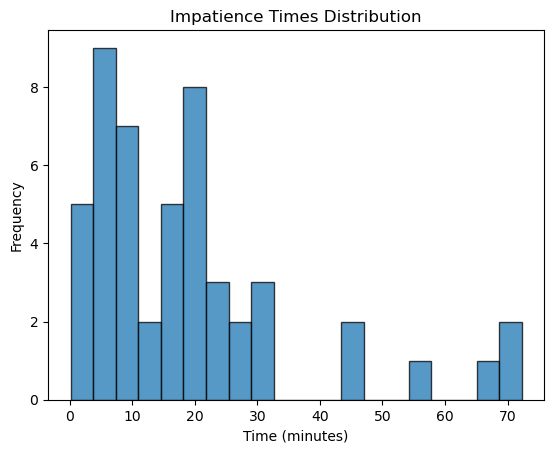

In [6]:
import simpy
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

RANDOM_SEED = 42
NUM_CUSTOMERS = 50
MEAN_ARRIVAL_INTERVAL = 5
APPOINTMENT_PROBABILITY = 0.2  # Müşterilerin randevulu olma olasılığı

# Makaleden alınan ortalama değerler
mean_order_wait = 7.23
mean_cook_time = 13.12
mean_eating_time = 40.56
mean_payment_time = 3.19
mean_impatience = 20

order_wait_times = []
cook_times = []
eating_times = []
payment_times = []
impatience_times = []
impatient_customers = 0
satisfied_customers = 0

def run_simulation(num_tables, num_waiters, num_chefs, num_cashiers):
    global order_wait_times, cook_times, eating_times, payment_times, impatience_times, impatient_customers, satisfied_customers
    order_wait_times = []
    cook_times = []
    eating_times = []
    payment_times = []
    impatience_times = []
    impatient_customers = 0
    satisfied_customers = 0

    class Restaurant:
        def __init__(self, env, num_tables, num_waiters, num_chefs, num_cashiers):
            self.env = env
            self.tables = simpy.PriorityResource(env, capacity=num_tables)
            self.waiters = simpy.PriorityResource(env, capacity=num_waiters)
            self.chefs = simpy.PriorityResource(env, capacity=num_chefs)
            self.cashiers = simpy.PriorityResource(env, capacity=num_cashiers)

    class Waiter:
        def __init__(self, env, restaurant):
            self.env = env
            self.restaurant = restaurant

        def take_order(self, customer):
            with self.restaurant.waiters.request(priority=customer.priority) as request:
                yield request
                order_wait_time = np.random.exponential(mean_order_wait)
                yield self.env.timeout(order_wait_time)
                order_wait_times.append(order_wait_time)
                yield self.env.process(self.deliver_food(customer))

        def deliver_food(self, customer):
            with self.restaurant.chefs.request(priority=customer.priority) as request:
                yield request
                cook_time = np.random.gamma(shape=2, scale=mean_cook_time/2)  # shape ve scale parametreleriyle gamma dağılımı
                yield self.env.timeout(cook_time)
                cook_times.append(cook_time)

    class Cashier:
        def __init__(self, env, restaurant):
            self.env = env
            self.restaurant = restaurant

        def process_payment(self, customer):
            with self.restaurant.cashiers.request(priority=customer.priority) as request:
                yield request
                payment_time = np.random.exponential(mean_payment_time)
                yield self.env.timeout(payment_time)
                payment_times.append(payment_time)

    class Customer:
        def __init__(self, env, name, restaurant, priority):
            self.env = env
            self.name = name
            self.restaurant = restaurant
            self.priority = priority
            self.action = env.process(self.run())
        
        def run(self):
            global impatient_customers, satisfied_customers
            with self.restaurant.tables.request(priority=self.priority) as request:
                patience = np.random.exponential(mean_impatience)
                impatience_times.append(patience)
                results = yield request | self.env.timeout(patience)
                if request in results:
                    waiter = Waiter(self.env, self.restaurant)
                    yield self.env.process(waiter.take_order(self))
                    start_eating_time = self.env.now
                    eating_time = np.random.normal(loc=mean_eating_time, scale=10)  # 10 dakikalık standart sapma ile normal dağılım
                    yield self.env.timeout(eating_time)
                    eating_times.append(eating_time)
                    cashier = Cashier(self.env, self.restaurant)
                    yield self.env.process(cashier.process_payment(self))
                    self.restaurant.tables.release(request)
                    satisfied_customers += 1
                else:
                    impatient_customers += 1

    def customer_arrivals(env, restaurant):
        for i in range(NUM_CUSTOMERS):
            priority = 0 if np.random.random() < APPOINTMENT_PROBABILITY else 1
            Customer(env, f"Customer-{i+1}", restaurant, priority)
            arrival_interval = np.random.exponential(MEAN_ARRIVAL_INTERVAL)
            yield env.timeout(arrival_interval)

    np.random.seed(RANDOM_SEED)  # Rastgele tohum
    env = simpy.Environment()
    restaurant = Restaurant(env, num_tables, num_waiters, num_chefs, num_cashiers)
    env.process(customer_arrivals(env, restaurant))
    env.run(until=800)

    return {
        "num_tables": num_tables,
        "num_waiters": num_waiters,
        "num_chefs": num_chefs,
        "num_cashiers": num_cashiers,
        "satisfied_customers": satisfied_customers,
        "impatient_customers": impatient_customers,
        "avg_order_wait_time": np.mean(order_wait_times) if order_wait_times else float('inf'),
        "avg_cook_time": np.mean(cook_times) if cook_times else float('inf'),
        "avg_eating_time": np.mean(eating_times) if eating_times else float('inf'),
        "avg_payment_time": np.mean(payment_times) if payment_times else float('inf'),
    }

num_tables_list = [1, 2, 3,4,5,20]
num_waiters_list = [1, 2]
num_chefs_list = [1, 2, 3]
num_cashiers_list = [1, 2, 3,100]


results = []
for num_tables, num_waiters, num_chefs, num_cashiers in product(num_tables_list, num_waiters_list,
                                                                num_chefs_list, num_cashiers_list):
    result = run_simulation(num_tables, num_waiters, num_chefs, num_cashiers)
    results.append(result)

# En iyi performansı bulan fonksiyon
def find_best_configuration(results):
    best_result = min(results, key=lambda x: (x['impatient_customers'], x['avg_order_wait_time'], x['avg_cook_time'], 
                                              x['avg_eating_time'], x['avg_payment_time']))
    return best_result

best_configuration = find_best_configuration(results)

print(f"Best configuration: {best_configuration}")

# Grafik fonksiyonlarını ekleyelim
def plot_distribution(data, title, xlabel):
    plt.hist(data, bins=20, alpha=0.75, edgecolor='black')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Frequency")
    plt.show()

# En iyi konfigürasyon ile simülasyonu tekrar çalıştır ve sonuçları görselleştir
best_num_tables = best_configuration['num_tables']
best_num_waiters = best_configuration['num_waiters']
best_num_chefs = best_configuration['num_chefs']
best_num_cashiers = best_configuration['num_cashiers']

run_simulation(best_num_tables, best_num_waiters, best_num_chefs, best_num_cashiers)

print(f"Total customers: {NUM_CUSTOMERS}")
print(f"Satisfied customers: {satisfied_customers}")
print(f"Impatient customers: {impatient_customers}")
print(f"Average order wait time: {np.mean(order_wait_times):.2f} minutes")
print(f"Average cook time: {np.mean(cook_times):.2f} minutes")
print(f"Average eating time: {np.mean(eating_times):.2f} minutes")
print(f"Average payment time: {np.mean(payment_times):.2f} minutes")

plot_distribution(order_wait_times, "Order Wait Times Distribution", "Time (minutes)")
plot_distribution(cook_times, "Cook Times Distribution", "Time (minutes)")
plot_distribution(eating_times, "Eating Times Distribution", "Time (minutes)")
plot_distribution(payment_times, "Payment Times Distribution", "Time (minutes)")
plot_distribution(impatience_times, "Impatience Times Distribution", "Time (minutes)")
